# Amazon SageMaker Models - Data Capture and Monitoring 
_**Hosting a trained machine learning model in Amazon SageMaker & capturing inference requests, results, and metadata from the hosted model**_

This notebook demonstrates 
* Hosting a trained machine learning model on Amazon SageMaker and capturing inference requests, results, and metadata
* Analyzing a baseline(training) dataset to generate a baseline constraints for the model
* Monitoring  live endpoint for violations against the baseline constraints. 

**Table of Contents** 

1. [Introduction](#intro)
2. [Section 1 - Setup](#setup)
3. [Section 2 - Deploy pre-trained model with model data capture enabled](#deploy)
4. [Section 3 - Run predictions and analyze data captured](#analyze-data-captured)
5. [Section 4 - Generate baseline statistics and constraints](#generate-baseline)
6. [Section 5 - Monitor model and analyze data drift](#analyze-data-drift)
7. [Section 6 - Retrigger Model Training](#retrigger-training)
8. [Clean up](#cleanup)


## Introduction <a id='intro'></a>

Amazon SageMaker provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly. Amazon SageMaker is a fully-managed service that covers the entire machine learning workflow. You can label and prepare your data, choose an algorithm, train a model, and then tune and optimize it for deployment. Amazon SageMaker gets your models into production to make predictions or take actions with less effort and lower costs than was previously possible.

Amazon SageMaker also provides capabilities that monitor ML models while in production and detect deviations in data quality in comparison to a baseline dataset (e.g. training data set). They enable you to capture the metadata and the input and output for invocations of the models that you deploy with Amazon SageMaker. They also enable you to analyze the data and monitor its quality. 

This notebook shows you how to capture the model invocation data from an endpoint and then view that data in S3. 

This notebook walks you through deploying a pretrained XGBoost movie recommendation model to a Amazon SageMaker RealTime Endpoint, send inference traffic to the endpoint and capture the model invocation data in an S3 bucket. It further shows how to perform continous monitoring of the deployed model, detect data drift and automatically rtrigger model retraining.

## Section 1 - Setup <a id='setup'></a>

In this section, we will import the necessary libraries, setup variables and examine data that was used to train the XGBoost movie recommendation model provided with this notebook.

Let's start by specifying:

* The AWS region used to host your model.
* The IAM role associated with this SageMaker notebook instance.
* The S3 bucket used to store the data used to train your model, any additional model data, and the data captured from model invocations.

#### Add the SageMaker Internal Model
This step is required to enable the data capture feature for beta.
<font color='red'>TODO : NEED TO REMOVE THIS AFTER GA</font> 

In [ ]:
!aws configure add-model --service-model file://sagemaker-internal-model.json --service-name sagemaker

#### 1.1 Import necessary libraries

In [ ]:
%%time

import os
import boto3
import re
import json
import pandas as pd
from sagemaker import get_execution_role, session

#### 1.2 AWS region and  IAM Role

In [ ]:
region = boto3.Session().region_name
print("AWS Region: {}".format(region))

role = get_execution_role()
print("RoleArn: {}".format(role))

#### 1.3 S3 bucket and prefixes to hold captured data from model

In [ ]:
##Look for the S3 buckets avialable in this account.  And pick the bucket with name starting with "deployment-options-workshopreinvent"
##Use this for the bucket name in the cell below.  
##bucket name should look like "bucket='deployment-options-workshopreinvent-xxxxxxxx'"

s3_client = boto3.Session().client('s3')
s3_client.list_buckets()

In [ ]:
bucket='deployment-options-workshopreinvent-8a6376f0'

prefix = 'sagemaker/XGBoost-Recommendations'

data_capture_prefix = '{}/datacapture'.format(prefix)
s3_capture_upload_path = 's3://{}/{}'.format(bucket, data_capture_prefix)
reports_prefix = '{}/reports'.format(prefix)
s3_report_path = 's3://{}/{}'.format(bucket,reports_prefix)
code_prefix = '{}/code'.format(prefix)
s3_code_preprocessor_uri = 's3://{}/{}/{}'.format(bucket,code_prefix, 'preprocessor.py')
s3_code_postprocessor_uri = 's3://{}/{}/{}'.format(bucket,code_prefix, 'postprocessor.py')

print("Capture path: {}".format(s3_capture_upload_path))
print("Report path: {}".format(s3_report_path))
print("Preproc Code path: {}".format(s3_code_preprocessor_uri))
print("Postproc Code path: {}".format(s3_code_postprocessor_uri))

#### 1.4 Pretrained movie recommendation model, training used and test data to use for inferences

In [ ]:
##Variables for pretrained models, baseline and test data
LOCAL_MODELS_DIR='../../models'
LOCAL_DATA_DIR='../../data'

MOVIE_RECOMMENDATION_MODEL='movie-rec-model.tar.gz'

MOVIE_RECOMMENDATION_TRAIN_DATA='movie_rec_training_data.csv'

MOVIE_RECOMMENDATION_TEST_DATA='movielens_users_items_for_predictions.csv'

MOVIE_RECOMMENDATION_BASELINE_DATA='movie_rec_baseline.csv'

MOVIE_META_DATA='movie_metadata.csv'

#### 1.5 Test access to the S3 bucket
Let's quickly verify that the notebook has the right permissions to access the S3 bucket specified above.
We will put a simple test object into the S3 bucket.  If this command fais, the data capture and model monioring capabilities will not work from this notebook.  You can fix this by updating the role associated with this notebook instnace to have "s3:PutObject" permissions and try this validation again

In [ ]:
# Let's go ahead and upload a sample test script.
boto3.Session().resource('s3').Bucket(bucket).Object("test_upload/test.txt").upload_file('test_data/upload-test-file.txt')
print("Success! You are all set to proceed.")

#### 1.6 Upload training data to S3 bucket.
This training data will be used by the triggered model re-training job later in Section 6

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object("train/" + MOVIE_RECOMMENDATION_TRAIN_DATA).upload_file(LOCAL_DATA_DIR + '/' + MOVIE_RECOMMENDATION_TRAIN_DATA)

#### 1.7 Define a method to get contents of object in S3.

In [105]:
def get_s3_obj_body(obj_key):
    return s3_client.get_object(Bucket=bucket, Key=obj_key).get('Body').read().decode("utf-8")

#### 1.8 Training data and features for movie recommendation model
For your convenience, a pre-trained XGBoost movie recommendation model is provided along with this notebook (available as "models/movie-rec-model.tar.gz")

The movie recommendation model was trained using the MovieLens data available from https://grouplens.org/datasets/movielens/

A sample of the training data (also used as a baseline in Section 4) is also provided as "data/movie_rec_baseline.csv" along with this notebook.

In the next few cell explore the features and a few rows of data.

In [107]:
movie_baseline_data = pd.read_csv(LOCAL_DATA_DIR + "/" + MOVIE_RECOMMENDATION_BASELINE_DATA)
movie_baseline_data.columns

Index(['Rating', 'User', 'Item', 'unknown', 'Action', 'Adventure',
       'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
       'Thriller', 'War', 'Western', 'Age', 'Zip Code', 'Gender_F', 'Gender_M',
       'Occupation_administrator', 'Occupation_artist', 'Occupation_doctor',
       'Occupation_educator', 'Occupation_engineer',
       'Occupation_entertainment', 'Occupation_executive',
       'Occupation_healthcare', 'Occupation_homemaker', 'Occupation_lawyer',
       'Occupation_librarian', 'Occupation_marketing', 'Occupation_none',
       'Occupation_other', 'Occupation_programmer', 'Occupation_retired',
       'Occupation_salesman', 'Occupation_scientist', 'Occupation_student',
       'Occupation_technician', 'Occupation_writer'],
      dtype='object')

###### Feature(s) - Description

    Rating - Movie rating provided by the user
    User   - ID of the user
    Item   - ID of the movie
    Next few columns ('unknown', 'Action' ... 'Western') - One hot encoding representation of movie genre
    Age    - Age of the user
    Zip Code - Zip Code of the user
    Gender_F, Gender_M - One hot encoding representation of user gender
    Next few columns ('Occupation_administrator', ... ''Occupation_writer') - One hot encoding representation of  user occupation

In [108]:
movie_baseline_data.head(5)

,Rating,User,Item,unknown,Action,Adventure,Children's,Comedy,Crime,Documentary,...,Occupation_marketing,Occupation_none,Occupation_other,Occupation_programmer,Occupation_retired,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer
0,4,500,381,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,659,73,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,385,208,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,435,72,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4,901,229,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In this notebook we will use various features (**Age, Movie Genre, ZipCode**) to discuss baseline violations and data drift.

## Section 2 - Deploy pre-trained movie recommendation model with model data capture enabled <a id='deploy'></a>

In this section, we will upload the pretrained model to the S3 bucket, create Amazon Sagemaker Model, configure Amazon SageMaker RealTime Endpoint with 'DataCapture' enabled and finally create the realtime endpoint.


#### 2.1 Upload the pre-trained model to S3

This code uploads a pre-trained XGBoost movie recommendation model that is ready for you to deploy.

In [ ]:
##Copy model to S3 bucket.
def copy_model_to_s3(model_name):
    key = prefix + "/" + model_name
    with open(LOCAL_MODELS_DIR+'/'+model_name, 'rb') as file_obj:
        print("Uploading ", file_obj , " to bucket ",bucket, " as " , key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_fileobj(file_obj)

In [ ]:
##Copy movie recommendation model to S3
copy_model_to_s3(MOVIE_RECOMMENDATION_MODEL)

#### 2.2 Create SageMaker Model entity

This step creates an Amazon SageMaker model from the movie recommendations model file previously uploaded to S3.

In [ ]:
%%time
from time import gmtime, strftime
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

model_name = "MoviePredictions-EndpointDataCaptureModel-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

sm_client = boto3.client('sagemaker')

model_url = 'https://{}.s3-{}.amazonaws.com/{}/{}'.format(bucket, region, prefix,MOVIE_RECOMMENDATION_MODEL)

print (model_url)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_url,
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

#### 2.3 Create Endpoint Configuration

This step is required to deploy an Amazon SageMaker model on a realtime endpoint.

To enable data capture for monitoring the model data quality, you specify the new capture option called "DataCaptureConfig". You can capture the request payload, the response payload or both with this configuration. Captured data is persisted in the S3 bucket location YOU specify and have complete control over.  This allows you to version this data, secure it with IAM policies, encryption according to your needs. 

The data capture is supported at the endpoint configuration level and applies to all variants. The captured data is stored in a json format. The comments in the cell below highlight the new API parameters for data capture.

In [ ]:
from time import gmtime, strftime

data_capture_sub_folder = "datacapture-xgboost-movie-recommendations"
s3_capture_upload_path = 's3://{}/{}'.format(bucket, data_capture_sub_folder)

print("Capture path:"+ s3_capture_upload_path)

data_capture_configuration = {
    "EnableCapture": True, # flag turns data capture on and off
    "InitialSamplingPercentage": 90, # sampling rate to capture data. max is 100%
    "DestinationS3Uri": s3_capture_upload_path, # s3 location where captured data is saved
    "CaptureOptions": [
        {
            "CaptureMode": "Output" # The type of capture this option enables. Values can be: [Output/Input]
        },
        {
            "CaptureMode": "Input" # The type of capture this option enables. Values can be: [Output/Input]
        }
    ],
    "CaptureContentTypeHeader": {
       "CsvContentTypes": ["text/csv"], # headers which should signal to decode the payload into CSV format 
       "JsonContentTypes": ["application/json"] # headers which should signal to decode the payload into JSON format 
     }
}

endpoint_config_name = 'XGBoost-MovieRec-DataCaptureEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m5.xlarge',
        'InitialInstanceCount':1,
        'InitialVariantWeight':1,
        'ModelName':model_name,
        'VariantName':'AllTrafficVariant'
    }],
    DataCaptureConfig = data_capture_configuration) # This is where the new capture options are applied

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

#### 2.4 Create Endpoint
This step uses the endpoint configuration specified above to create an endpoint. This takes a few minutes (approximately 10 minutes) to complete.

In [ ]:
%%time
import time

endpoint_name = 'XGBoost-RW-MovieRec-DataCaptureEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

## Section 3 - Execute movie predictions and analyze data captured from the deployed movie recommendation model <a id='analyze-data-captured'></a>

In this section, we will invoke the enpoint created above using test data.  Since we already enabled 'datacapture' on the endpoint, the request payload and response along with additional metadata will be saved in the S3 location you have specified.  We will examine the data captured in the S3 bucket.


#### 3.1  Invoke the Deployed Model

In [ ]:
movie_df = pd.read_csv(LOCAL_DATA_DIR+"/"+MOVIE_META_DATA, delimiter ='|', encoding='latin-1')

movie_df.columns = ["movie id", "movie title", "release date", "video release date",
              "IMDb URL", "unknown", "Action", "Adventure", "Animation",
              "Children's","Comedy","Crime","Documentary","Drama","Fantasy",
              "Film-Noir","Horror","Musical","Mystery", "Romance","Sci-Fi",
              "Thriller","War","Western"]

#movie_df

In [ ]:
runtime_client = boto3.client('runtime.sagemaker')

def get_recommendations_for_user(user_id, show_predictions):
    predictions_for_user = str(user_id)
    predictions = []
    
    with open(LOCAL_DATA_DIR+"/"+MOVIE_RECOMMENDATION_TEST_DATA, 'r') as f:
        contents = f.readlines() 
    
    for i in range(0, len(contents) - 1):
        line = contents[i]
        split_data = line.split(',')
        #Remove the original rating value from data used for prediction
        original_value = split_data.pop(0)
        original_value = split_data.pop(0)
        #print('original rating ', original_value)

        user = split_data[0]
        item = split_data[1]
        #print('Predicting rating for User ', user, 'for item ', item)

        if (user == predictions_for_user) : 

            payload = ','.join(split_data)

            response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                                  ContentType='text/csv', 
                                                  Body=payload)
            prediction = response['Body'].read().decode('utf-8')

            predictions.append([item, prediction])

            #print("Original Value ", original_value , "Prediction : ", float(prediction))

    if show_predictions:        
        sorted_predcitions =    sorted(predictions, key = lambda x: x[1], reverse=True)     

        ## Let's show only the top 10 recommendations
        recommendations = sorted_predcitions[0:9]

        print("Recommended movies for user with id : ", predictions_for_user)
        for rec in recommendations: 
            #print("rec is ", type(rec))
            movie_id = int(rec[0])
            #print("recommended_movie_item ", movie_id)
            movie_match = movie_df.loc[movie_df['movie id'] == movie_id]
            movie_titile = movie_match['movie title'].values[0]
            print("\t", movie_match['movie title'].values[0] )
    
    

In [ ]:
## Get movie recommendations for a couple of users.
user_ids = [100, 235]

for user_id in user_ids:
    get_recommendations_for_user(user_id, True)
    time.sleep(10)

#### 3.2 View Captured Data : List files

Let's list the data capture files stored in S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred. 

The format of the s3 path is:
s3://{destination-bucket-prefix}/{endpoint-name}/{variant-name}/yyyy/mm/dd/hh/filename.jsonl

In [ ]:
s3_client = boto3.Session().client('s3')
result = s3_client.list_objects(Bucket=bucket, Prefix=data_capture_sub_folder)
print("Looking for captured files in : " , data_capture_sub_folder)

while(result.get('Contents') == None):
    time.sleep(30)
    print("Looking for captured files in : " , data_capture_sub_folder)
    result = s3_client.list_objects(Bucket=bucket, Prefix=data_capture_sub_folder)
    
capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]

print("Found Capture Files.  Showing upto five files captured")
print("\n ".join(capture_files[0:5]))

Next, we are going to copy the captured files for the current hour to previous hour location in S3 bucket.  The monitoring job that we will schedule in Section 5 may possibly look for files captured in the previous hour, depending on when the job is kicked off.  If datacapture files are not available, the monitoring job will fail.

**NOTE** This step is necessary **ONLY** in the workshop setting, due to the limited time we have available for data capture.  In real world setting, data capture would be continous and readily available for the monitoring job. 

In [ ]:
current_hour_prefix=strftime("%Y/%m/%d/%H", gmtime())

current_hour=strftime("%H", gmtime())
#print("current_hour  : ",current_hour)
previous_hour=int(current_hour) - 1
#print("previous_hour  : ",previous_hour)

print("current_hour_prefix  : ", current_hour_prefix)
previous_hour_prefix=strftime("%Y/%m/%d/"+str(previous_hour), gmtime())
print("previous_hour_prefix  : ", previous_hour_prefix)

  
prefix_for_endpoint_captured_files = data_capture_sub_folder+"/"+endpoint_name+"/AllTrafficVariant/"
prefix_for_endpoint_captured_files_current_hour = prefix_for_endpoint_captured_files+current_hour_prefix
prefix_for_endpoint_captured_files_previous_hour = prefix_for_endpoint_captured_files+previous_hour_prefix

print("Checking for captured files for current hour at prefix ", prefix_for_endpoint_captured_files_current_hour)
result = s3_client.list_objects(Bucket=bucket, Prefix=prefix_for_endpoint_captured_files_current_hour)

files_found=[]

if result.get('Contents'):
    print("\tFound Capture Files:")
    
    for capture_file in result.get('Contents'):
        print("capture file ", capture_file)
        key_name_parts = capture_file['Key'].split("/")
        file_name = key_name_parts[-1]
        print("File name ", file_name)
        files_found.append(file_name)

    capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
    print("\n ".join(capture_files))

print("Checking for captured files for previous hour at prefix ", prefix_for_endpoint_captured_files_previous_hour)

result = s3_client.list_objects(Bucket=bucket, Prefix=prefix_for_endpoint_captured_files_previous_hour)

if result.get('Contents'):
    print("\tFound Capture Files:")
    capture_files = [capture_file.get("Key") for capture_file in result.get('Contents')]
else:
    print("\tDid not find any Capture Files:")
    
    #Let's copy from the current hour
    ##Copy the file with key 
    for file in files_found:
        key = prefix_for_endpoint_captured_files_current_hour+"/"+file
        copy_source = {'Bucket': bucket, 'Key': key }
        print("Copying ", key , " to ", prefix_for_endpoint_captured_files_previous_hour+"/"+file)
        s3_client.copy_object(CopySource=copy_source, 
                              Bucket=bucket,
                              Key=prefix_for_endpoint_captured_files_previous_hour+"/"+file)

#### 3.3 View Captured Data : View captured file content

Next, let's view the contents of a single capture file. Here you should see all the data captured in a json-line formatted file. For each inference made against the real time endpoint, a single line is captured.

In [90]:
capture_file = get_s3_obj_body(capture_files[-1])

print(capture_file[0:1000])

{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"100,258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,36.0,90254,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"3.7835195064544678","encoding":"CSV"}},"eventMetadata":{"eventId":"6a56a0b1-19fe-41b2-bb35-279c902b4716","inferenceTime":"2019-12-04T03:12:43Z"},"eventVersion":"0"}
{"captureData":{"endpointInput":{"observedContentType":"text/csv","mode":"INPUT","data":"100,269,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,90254,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0\n","encoding":"CSV"},"endpointOutput":{"observedContentType":"text/csv; charset=utf-8","mode":"OUTPUT","data":"3.6359450817108154","encoding":"CSV"}},"eventMetadata":{"eventId":"69a49d9d-5de7-4d9c-8b40-68fe1407c17b","inferenceTime":"2019-12-04T03:12:43Z"},"eventVersion":"

#### 3.4 View Captured Data : View single line captured

Finally, let's view the contents of a single line. For each inference endpoint input, endpoint output and event meta data is captured.

In [ ]:
import json
print(json.dumps(json.loads(capture_file.split('\n')[0]), indent=2))

## Section 4 – Generate baseline statistics and constraints for continous model monitoring <a id='generate-baseline'></a>

In this section, we will ask Amazon SageMaker to  suggest a set of baseline constraints and generate descriptive statistics to explain the data. We will review the generated constraints and statistics

#### 4.1 Upload baseline data to S3
Training dataset which was used for training the xgboost movie recommendation model is provided with this notebook.  We will first upload this training dataset as baseline  to S3 bucket.

In [ ]:
# copy over the training dataset to S3 
baseline_prefix = prefix + '/baselining'
baseline_data_prefix = baseline_prefix + '/data'
baseline_results_prefix = baseline_prefix + '/results'

baseline_data_uri = 's3://{}/{}'.format(bucket,baseline_data_prefix)
baseline_results_uri = 's3://{}/{}'.format(bucket, baseline_results_prefix)
print(baseline_data_uri)
print(baseline_results_uri)

In [ ]:
baseline_data_file = open(LOCAL_DATA_DIR+"/"+MOVIE_RECOMMENDATION_BASELINE_DATA, 'rb')
s3_key = os.path.join(baseline_prefix, 'data', 'baseline.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(s3_key).upload_fileobj(baseline_data_file)

#### 4.2 Generate suggested constraints with baseline/training dataset using a Processing job

Let's ask SageMaker to suggest a set of baseline constraints and generate descriptive statistics to explore the data, using the uploaded baseline dataset.  For this, we will create a Processing job

(This step will take approximately 6 min)


In [ ]:
%%time
import time

from processingjob_wrapper import ProcessingJob
from time import gmtime, strftime

job_name = 'MOVIE-REC-baseline-xgb-model-monitor-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
processing_job = ProcessingJob(sm_client, role).create(job_name, baseline_data_uri, baseline_results_uri)

resp = sm_client.describe_processing_job(ProcessingJobName=job_name)
status = resp['ProcessingJobStatus']
print("Status: " + status)

while status=='InProgress':
    time.sleep(60)
    resp = sm_client.describe_processing_job(ProcessingJobName=job_name)
    status = resp['ProcessingJobStatus']
    print("Status: " + status)

if status=='Failed':
    print(resp)  

#### 4.3 Explore the generated constraints and statistics


In [ ]:
result = s3_client.list_objects(Bucket=bucket, Prefix=baseline_results_prefix)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Files:")
print("\n ".join(report_files))

In [91]:
constraints_file = get_s3_obj_body(baseline_results_prefix+'/constraints.json')
#print(constraints_file[:4000])
print(constraints_file)
##Point out the various inferred_type.  Fractional, Integral, String (ZipCode),
##TODO : Why are the genres treated as fractional?  
##TODO : Would making rating fractional makes more sense?
##TODO : What are all available inferred_types available and can we show them all?
##TODO : set age level constraint ?  Gender level constraint
##TODO : ADD explanation of the constraints
###TODO : Better rendering from the pysdk sample notebook.  Can we render as histograms as well??

##Lets add details of these monitoring config settings.  Arun to forward the document.
##Featurre level override is also available.

##Base line 20 cols, but inference has 21 cols -- extra column check (what happens if we send 1 less column)
## How about if one col is null ?? Completeness constraint.


## Good to include in deck
## Other Drift examples : loan applicaiton model.  loan approved/not; how much.  csutomers start using mobile and apply high amount.
## could have caught in the drift.

## DS retrained model based on a pivot in a single dimension.  now data formats coming in new inference.
## new applicaiton inference traffic formats.  



{
  "version" : 0.0,
  "features" : [ {
    "name" : "Rating",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "User",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "Item",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "unknown",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "Action",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "Adventure",
    "inferred_type" : "Integral",
    "completeness" : 1.0,
    "num_constraints" : {
      "is_non_negative" : true
    }
  }, {
    "name" : "Children's",
    "inferred_t

From the above results examine the monitoring constraints section at the end of the constriants file.  Note that these constraints are suggestions from Amazon SageMaker.  You can choose to override these values.  You can even update this file to include feature level constraint override.

In [95]:
statistics_file = get_s3_obj_body(baseline_results_prefix+'/statistics.json')

,num_present,num_missing,mean,sum,std_dev,min,max
Rating,63398,0,3.519654,223139.0,1.128394,1.0,5.0
User,63398,0,461.514101,29259071.0,265.993372,1.0,943.0
Item,63398,0,428.845768,27187964.0,332.829669,1.0,1682.0
unknown,63398,0,0.000126,8.0,0.011233,0.0,1.0
Action,63398,0,0.256412,16256.0,0.436652,0.0,1.0
Adventure,63398,0,0.138616,8788.0,0.345546,0.0,1.0
Children's,63398,0,0.068930,4370.0,0.253334,0.0,1.0
Comedy,63398,0,0.296019,18767.0,0.456499,0.0,1.0
Crime,63398,0,0.080066,5076.0,0.271395,0.0,1.0
Documentary,63398,0,0.007713,489.0,0.087485,0.0,1.0


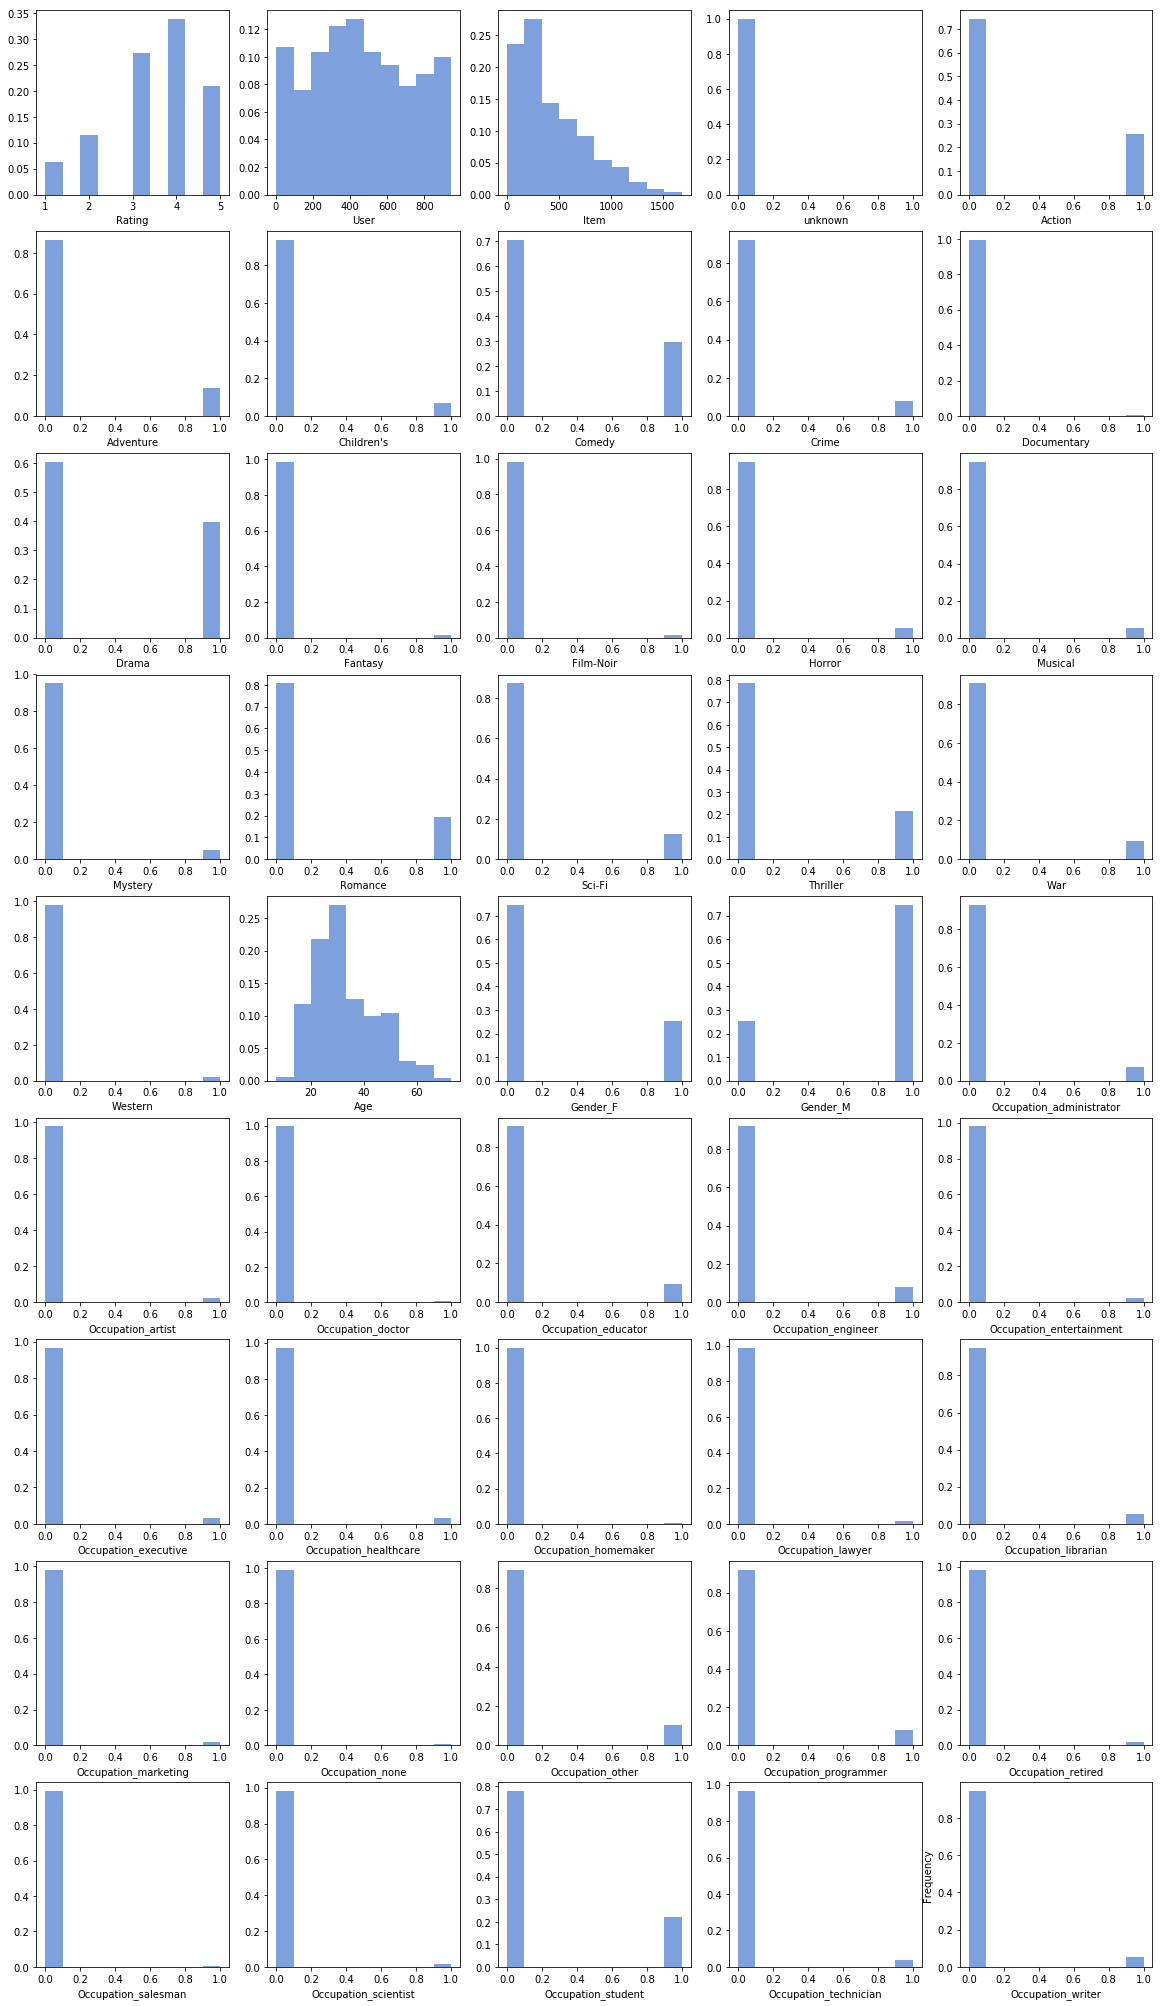

,num_present,num_missing,distinct_count
Zip Code,63398,0,767.0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


RuntimeError: libpng signaled error

<Figure size 1440x0 with 1 Axes>

In [96]:
## Render the statistics a tabular format
import monitor_render_utils as mu

#load the json to a string
statistics_file_json = json.loads(statistics_file)

feature_baselines = mu.get_features(statistics_file_json)
mu.show_distributions(feature_baselines)

In [97]:
## Render constraints in a tabular format.
## TODO : WHAT OTHER CONSTRAINTS CAN WE SHOW
constraints_json = json.loads(constraints_file)
schema_df = pd.io.json.json_normalize(constraints_json['features'])
schema_df

,completeness,inferred_type,name,num_constraints.is_non_negative
0,1.0,Integral,Rating,True
1,1.0,Integral,User,True
2,1.0,Integral,Item,True
3,1.0,Integral,unknown,True
4,1.0,Integral,Action,True
5,1.0,Integral,Adventure,True
6,1.0,Integral,Children's,True
7,1.0,Integral,Comedy,True
8,1.0,Integral,Crime,True
9,1.0,Integral,Documentary,True


## Section 5 – Monitor and analyze model for data drift <a id='analyze-data-drift'></a>

So far we have captured data based on inferences to the deployed realtime endpoint and explored the baseline data contraints and statistics.  In this section, we will take this a step forward and configure continuous monitoring using 'Monitoring Schedules'.  We will further use results of various monitoring schedule executions to analyse inference data quality and detect data drift.

**Note** that the datacapture capability can be used independent of model monitoring.  Gaining understanding of the baseline/inference data and the model can benefit is your usecase regardless of whether you choose to continously monitor the deployed models in production.


#### 5.1 Create a schedule
Let's create a Monitoring schedule for the previously created Endpoint

In [ ]:
# first copy over some test scripts to the S3 bucket so that they can be used for pre and post processing
## HOW SHOULD WE USE preprocessor /postprocessor FOR THE WORKSHOP??
## IS This for baseline data? or inference data?

## OPTIONAL /ADVANCED SECTION 
#multiple schedules
#BYOC
#infereance data capture --> should match the baseline
#independent of the data capture
#Prebuilt rules assume certain data structure/format.

##TODO : WE NEED TO DELETE THIS?  ACTUALLY, MOVE TO AN ADVANCED SECTION

##NEED THESE FILES FOR MONITORING SCHEDULE JOB TO WORK

## Pre processing -- 
## Post processing -- write additonal file as are report?
boto3.Session().resource('s3').Bucket(bucket).Object(code_prefix+"/preprocessor.py").upload_file('preprocessor.py')
boto3.Session().resource('s3').Bucket(bucket).Object(code_prefix+"/postprocessor.py").upload_file('postprocessor.py')

In [ ]:
from schedule_wrapper import MonitoringSchedule
from time import gmtime, strftime

# MonitoringSchedule is just a python helper to hide the large CreateMonitoringSchedule input payload. You can find it
# in scheduler_wrapper.py in this package

ms = MonitoringSchedule(sm_client, role)
mon_schedule_name = 'REC-SM-xgb-movie-rec-model-monitor-schedule-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
schedule = ms.create(mon_schedule_name, endpoint_name, s3_report_path, 
                     record_preprocessor_source_uri=s3_code_preprocessor_uri, 
                     post_analytics_source_uri=s3_code_postprocessor_uri,
                     baseline_statistics_uri=baseline_results_uri + '/statistics.json',
                     baseline_constraints_uri=baseline_results_uri+ '/constraints.json')


schedule

In [ ]:
desc_schedule_result = sm_client.describe_monitoring_schedule( MonitoringScheduleName=mon_schedule_name)
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

#### 5.2 Generate inference traffic 

Start generating some inference traffic. The block below kicks off a thread to send traffic to the created endpoint. Note that you need to stop the kernel to terminate this thread. Just having this here so that it can continue to generate traffic. If there is no traffic, the monitoring jobs will start to fail later on.

In [ ]:
from threading import Thread
from time import sleep
import time

user_ids = [100, 235, 40, 500, 300, 500, 600, 489, 293, 95]

def invoke_endpoint_forever():
    while True:
        #invoke_endpoint(endpoint_name, LOCAL_DATA_DIR+"/"+MOVIE_RECOMMENDATION_TEST_DATA, runtime_client)
        for user_id in user_ids:
            get_recommendations_for_user(user_id, False)
        
thread = Thread(target = invoke_endpoint_forever)
thread.start()

#### 5.3 Describe and inspect the schedule.  
Once you describe, see MonitoringScheduleStatus changes to Scheduled

In [ ]:
desc_schedule_result = sm_client.describe_monitoring_schedule( MonitoringScheduleName=mon_schedule_name)
print('Schedule status: {}'.format(desc_schedule_result['MonitoringScheduleStatus']))

#### 5.4 List executions 
List executions
Once the schedule is scheduled, it will kick of jobs at specified intervals. Here we are listing the latest 5 executions. Note that if you are kicking this off after creating the hourly schedule, you might find the executions empty. You might have to wait till you cross the hour boundary (in UTC) to see executions kick off.

In [ ]:
mon_executions = sm_client.list_monitoring_executions(MonitoringScheduleName=mon_schedule_name.lower(), MaxResults=5)
mon_executions

#### 5.5 Wait for first execution of the monitoring schedule

First execution of the monitoring schedule will happen ON the hour mark.  This cell waits for the first execution.

**Note** Since this cell execution could potentially take a long time waiting, leave this cell running and explore the rest of this section.  For your convinience, sample outputs for next few cells are included for you to examine.
Please **DO NOT** close this notebook till executions of this cell is complete.

In [ ]:
mon_executions = sm_client.list_monitoring_executions(MonitoringScheduleName=mon_schedule_name.lower(), MaxResults=5)
latest_execution=None

# Wait till an execution occurs
while not mon_executions['MonitoringExecutionSummaries']:
    print("Waiting for the 1st execution to happen...")
    time.sleep(60)
    mon_executions = sm_client.list_monitoring_executions(MonitoringScheduleName=mon_schedule_name.lower(), MaxResults=5)
    

#### 5.6 Wait for completion of first monitoring schedule execution

You should see "Processing Job Status: InProgress"

In [ ]:
mon_executions = sm_client.list_monitoring_executions(MonitoringScheduleName=mon_schedule_name.lower(), MaxResults=5)

if len(mon_executions['MonitoringExecutionSummaries']) == 1: 
    execution = mon_executions['MonitoringExecutionSummaries'][0]
    while True:
        if execution['ProcessingJobArn']:
            job_name = execution['ProcessingJobArn'].split('/')[1]    
            resp = sm_client.describe_processing_job(ProcessingJobName=job_name)
            status = resp['ProcessingJobStatus']
            print("Processing Job Status: " + status)
            if status != 'InProgress':
                break
        time.sleep(60)

#### 5.7 Get the latest execution details 

In [ ]:
# Now get the latest execution details 
mon_executions = sm_client.list_monitoring_executions(MonitoringScheduleName=mon_schedule_name.lower(), MaxResults=5)

for execution_summary in mon_executions['MonitoringExecutionSummaries']:
    print("ProcessingJob: {}".format(execution_summary['ProcessingJobArn'].split('/')[1]))
    print('MonitoringExecutionStatus: {} \n'.format(execution_summary['MonitoringExecutionStatus']))
    print("execution_summary is " , execution_summary)
    print("latest_executions is " , latest_execution)    
    if not latest_execution:
        exec_status = execution_summary['MonitoringExecutionStatus']
        print("exec_status is " , exec_status)    
        if  exec_status == 'Completed' or exec_status == 'Failed' or exec_status == 'CompletedWithViolations':
            latest_execution = execution_summary
            
print("latest_executions is " , latest_execution)          

List the monitoring executions to examine thier state.  Possible terminal states for monitoring schedule execution are 

* Completed - Monitoring execution is completed and no issues were found in the violations report

* CompletedWithViolations - Monitoring execution is completed, but constraint violations were detected

* Failed - Monitoring execution failed, may be due to client error (say role issues) or infrastructure issues. Further examination of FailureReason and ExitMessage is necessary to identify what exactly happened.

In [ ]:
sm_client.list_monitoring_executions(MonitoringScheduleName=mon_schedule_name.lower(), MaxResults=5)


SAMPLE OUTPUT

You can see that atleast one of the monitoring schedule executions is in 'CompletedWithViolations'. You will explore the violations in the next few cells.

<div style="background-color:orange; text-align:center; vertical-align: middle; padding:40px 0;">
<img src="images/MonitoringExecutionsSummary.png"/>
</div>


#### 5.8 Inspect a specific execution (latest execution here).

In the previous cell, we picked up the latest Completed/Failed scheduled execution. First let's see where are the results are stored in S3

In [ ]:
if latest_execution:
    job_name=latest_execution['ProcessingJobArn'].split('/')[1]
    print('Processing job ARN ', job_name)
    job_status=latest_execution['MonitoringExecutionStatus']
    desc_analytics_job_result=sm_client.describe_processing_job(ProcessingJobName=job_name)
    
    if job_status == 'Completed' or job_status == 'CompletedWithViolations':
        report_uri=desc_analytics_job_result['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
        print('Report Uri: {}'.format(report_uri))
    else:
        print('Job failed.')
else:
    print("====STOP==== \n No completed executions to inspect further. Please wait till an execution completes or investigate previously reported failures.")

SAMPLE OUTPUT : REPORT FILE LOCATION

<div style="background-color:orange; text-align:center; vertical-align: middle; padding:40px 0;">
<img src="images/ReportURI.png"/>
</div>

#### 5.9 List the generated reports

Next, let's look at the report file names

In [ ]:
from urllib.parse import urlparse
s3uri = urlparse(report_uri)
report_bucket = s3uri.netloc
report_key = s3uri.path.lstrip('/')
print('Report bucket: {}'.format(report_bucket))
print('Report key: {}'.format(report_key))

result = s3_client.list_objects(Bucket=report_bucket, Prefix=report_key)
report_files = [report_file.get("Key") for report_file in result.get('Contents')]
print("Found Report Files:")
print("\n ".join(report_files))

SAMPLE OUTPUT : REPORTS FILES

<div style="background-color:orange; text-align:center; vertical-align: middle; padding:40px 0;">
<img src="images/ReportFiles.png"/>
</div>

#### 5.10 Violations report

If there are any violations observed in the inference traffic compared to the baseline data, it will be generated here. Let's list the violations.

<font color='red'> TODO : Add explanation to one or two features : 'Age' and 'Gender'? </font>

In [93]:
violations_file = get_s3_obj_body(report_key+'/constraint_violations.json')
print(violations_file)

{
  "violations" : [ {
    "feature_name" : "Drama",
    "constraint_check_type" : "data_type_check",
    "description" : "Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 0.0% of data is Integral."
  }, {
    "feature_name" : "Comedy",
    "constraint_check_type" : "data_type_check",
    "description" : "Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 0.0% of data is Integral."
  }, {
    "feature_name" : "Zip Code",
    "constraint_check_type" : "data_type_check",
    "description" : "Data type match requirement is not met. Expected data type: String, Expected match: 100.0%. Observed: Only 0.0% of data is String."
  }, {
    "feature_name" : "Film-Noir",
    "constraint_check_type" : "data_type_check",
    "description" : "Data type match requirement is not met. Expected data type: Integral, Expected match: 100.0%. Observed: Only 0.0% of data is Integral."
  }, {
 

SAMPLE OUTPUT : VIOLATIONS REPORT

<div style="background-color:orange; text-align:center; vertical-align: middle; padding:40px 0;">
<img src="images/Violations.png"/>
</div>

## Section 6 - Retrigger Training <a id='retrigger-training'></a>

Now that we know how to capture the violations, in this section we can go a step further and automatically trigger retraining of the movie recommendation model.  We rely on Amazon CloudWatch metrics and alerts for this.

For the purposes of this workshop, we provide the training data to be used for retraining the model.  You uploaded this to an S3 bucket in Section 1.  In real life situations, this training data may be collected and persisted to S3 overtime.

#### 6.1 Get the right SNS topic to use.

List all the SNS topics available.
Make note of the topic ARN that consists of 'RetrainSNSTopic'

In [ ]:
client = boto3.client('sns')

client.list_topics()

In [ ]:
sns_notifications_topic='<<REPLACE_SNS_TOPIC_ARN>>'

#### 6.2 Create Cloud Watch Alarms

In [ ]:
cw_client = boto3.Session().client('cloudwatch')

alarm_name='BASELINE_DRIFT_FEATURE_AGE'
alarm_desc='Trigger an cloudwatch alarm when the feature age drifts away from the baseline'
feature_age_drift_threshold=0.1 ##Setting this threshold purposefully slow to see the alarm quickly.
metric_name='feature_baseline_drift_Age'
namespace='aws/sagemaker/Endpoints/data-metrics'

endpoint_name=endpoint_name
monitoring_schedule_name=mon_schedule_name

cw_client.put_metric_alarm(
    AlarmName=alarm_name,
    AlarmDescription=alarm_desc,
    ActionsEnabled=True,
    AlarmActions=[sns_notifications_topic],
    MetricName=metric_name,
    Namespace=namespace,
    Statistic='Average',
    Dimensions=[
        {
            'Name': 'Endpoint',
            'Value': endpoint_name
        },
        {
            'Name': 'MonitoringSchedule',
            'Value': monitoring_schedule_name
        }
    ],
    Period=600,
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=feature_age_drift_threshold,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='breaching'
)


#### Validation - 1

In a few minutes, you should see a cloudwatch alarm created. The alarm will first be in "Insufficient Data" state and moves into "Alert" state.  This can be verified in the CloudWatch console

![title](images/CloudWatchAlarm_InsufficientData.png)

![title](images/CloudWatchAlarm_Alert.png)



#### Validation - 2

In a few minutes, you should also see a new SageMaker model training job is triggered.  This can be verified in the SageMaker Console


![title](images/ModelRetraining.png)



## (Optional) Cleanup : Delete the Resources <a id='cleanup'></a>

You can keep your Endpoint running to continue capturing data. If you do not plan to collect more data or use this endpoint further, you should delete the endpoint to avoid incurring additional charges. Note that deleting your endpoint does not delete the data that was captured during the model invocaations. That data is persisted in S3 until you delete it yourself.

In [ ]:
sm_client.list_monitoring_executions()

In [ ]:
#mon_schedule_name='REC-SM-xgb-movie-rec-model-monitor-schedule-2019-12-03-18-06-00'
sm_client.delete_monitoring_schedule(MonitoringScheduleName=mon_schedule_name)

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

In [ ]:
sm_client.delete_model(ModelName=model_name)

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-51-abede7787b11>", line 11, in invoke_endpoint_forever
    get_recommendations_for_user(user_id, False)
  File "<ipython-input-22-f6dc76b7affa>", line 28, in get_recommendations_for_user
    Body=payload)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 357, in _api_call
    return False
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 661, in _make_api_call
    actual_operation_name]
botocore.errorfactory.ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint XGBoost-RW-MovieRec-DataCaptureEndpoi